# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [ ]:
!pip install --upgrade pandas_datareader

     |████████████████████████████████| 109 kB 4.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

## Pandas Reader

<a href="https://pandas-datareader.readthedocs.io/en/latest/">Documentation</a>

In [ ]:
''' Reading stock data from Yahoo for example'''
from pandas_datareader.data import DataReader

''' Hnadling timestamps'''
import datetime
from datetime import datetime

In [ ]:
# tech stocks
tech_list = ['AAPL', 'GOOG','MSFT', 'AMZN']

In [ ]:
# today
end = datetime.now()

In [ ]:
# 10 years ago
start = datetime(end.year-10, 1, 1)
start

datetime.datetime(2011, 1, 1, 0, 0)

In [ ]:
stock_prices = {}

for tech in tech_list:
    stock_prices[tech] = DataReader(tech, 'yahoo', start, end)

In [ ]:
stock_prices.keys()

dict_keys(['AAPL', 'GOOG', 'MSFT', 'AMZN'])

In [ ]:
for k,v in stock_prices.items():
    print(f"---- {k} stock price during the last 3 days -----")
    print(v.shape)
    display(v.tail(3))
    print("")

---- AAPL stock price during the last 3 days -----
(2679, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-08-20,148.500000,146.779999,147.440002,148.190002,59947400.0,148.190002
2021-08-23,150.190002,147.889999,148.309998,149.710007,60007400.0,149.710007
2021-08-24,150.860001,149.149994,149.449997,150.544998,10589769.0,150.544998



---- GOOG stock price during the last 3 days -----
(2679, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-08-20,2772.290039,2729.340088,2741.659912,2768.739990,778200.0,2768.739990
2021-08-23,2843.540039,2774.958984,2779.969971,2821.989990,1053800.0,2821.989990
2021-08-24,2848.310059,2827.300049,2830.870117,2844.810059,139900.0,2844.810059



---- MSFT stock price during the last 3 days -----
(2679, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-08-20,305.839996,298.059998,299.720001,304.359985,40796100.0,304.359985
2021-08-23,305.399994,301.850006,303.250000,304.649994,22810800.0,304.649994
2021-08-24,305.640015,303.260010,305.019989,303.940002,2703922.0,303.940002



---- AMZN stock price during the last 3 days -----
(2679, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-08-20,3207.810059,3175.76001,3203.870117,3199.949951,3341200,3199.949951
2021-08-23,3280.899902,3210.01001,3211.899902,3265.870117,3260900,3265.870117
2021-08-24,3297.889893,3274.98999,3280.000000,3278.899902,441542,3278.899902


In [ ]:
company_list = list(stock_prices.keys())
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    stock_prices[company]["company_name"] = com_name

In [ ]:
df = pd.concat([stock_prices[tech_company] for tech_company in company_list], ignore_index=True)

In [ ]:
df.sample(10)

,High,Low,Open,Close,Volume,Adj Close,company_name
166,13.994286,13.793214,13.866071,13.928214,417922400.0,11.958991,APPLE
4682,1049.479980,1021.440002,1026.089966,1028.709961,2192500.0,1028.709961,GOOGLE
3717,541.622986,536.536926,536.566833,541.383606,989108.0,541.383606,GOOGLE
10507,3282.979980,3153.300049,3198.739990,3207.040039,5901200.0,3207.040039,AMAZON
6997,70.250000,69.199997,69.459999,69.980003,15014500.0,65.956017,MICROSOFT
4133,788.130005,782.059998,783.760010,786.140015,937400.0,786.140015,GOOGLE
457,22.376785,21.808571,22.194286,22.029642,558527200.0,18.996225,APPLE
9822,1443.989990,1351.790039,1361.459961,1442.839966,11066800.0,1442.839966,AMAZON
163,13.408929,13.035714,13.038571,13.347143,871346000.0,11.460076,APPLE
1101,32.744999,32.334999,32.500000,32.514999,145819600.0,29.721012,APPLE


In [ ]:
df[df.company_name == "APPLE"].describe()

,High,Low,Open,Close,Volume,Adj Close
count,2679.000000,2679.000000,2679.000000,2679.000000,2.679000e+03,2679.000000
mean,42.502375,41.630964,42.066176,42.084140,2.454457e+08,40.319384
std,33.536440,32.728991,33.135767,33.154263,1.981640e+08,33.722336
min,11.346429,11.089286,11.310000,11.261429,1.058977e+07,9.669245
25%,20.428392,20.031250,20.287499,20.256786,1.088908e+08,17.580548
50%,29.412500,28.937500,29.184999,29.152500,1.731832e+08,27.096560
75%,48.406250,47.607500,47.930000,47.963751,3.201912e+08,46.613104
max,151.679993,149.149994,150.229996,151.119995,1.880998e+09,151.119995


## Time-Series Visualisation

### Historical Stock Prices

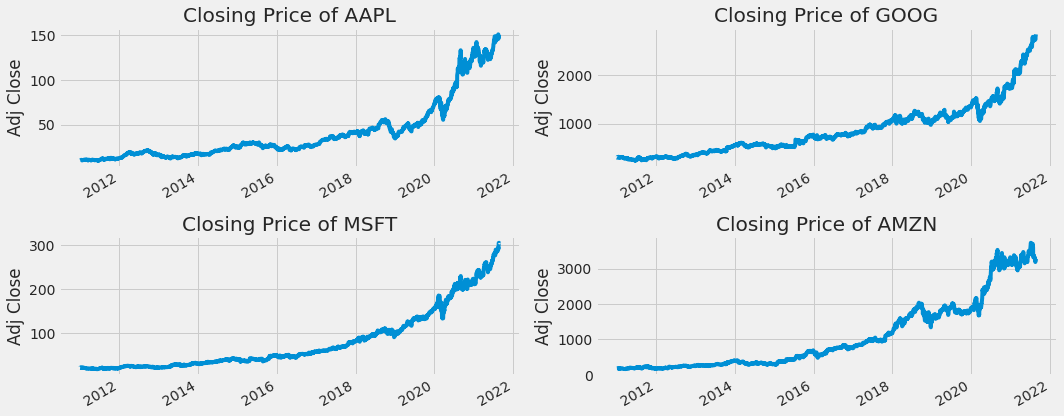

In [ ]:
# Let's see a historical view of the closing price


plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    stock_prices[company]['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

### Volumes traded

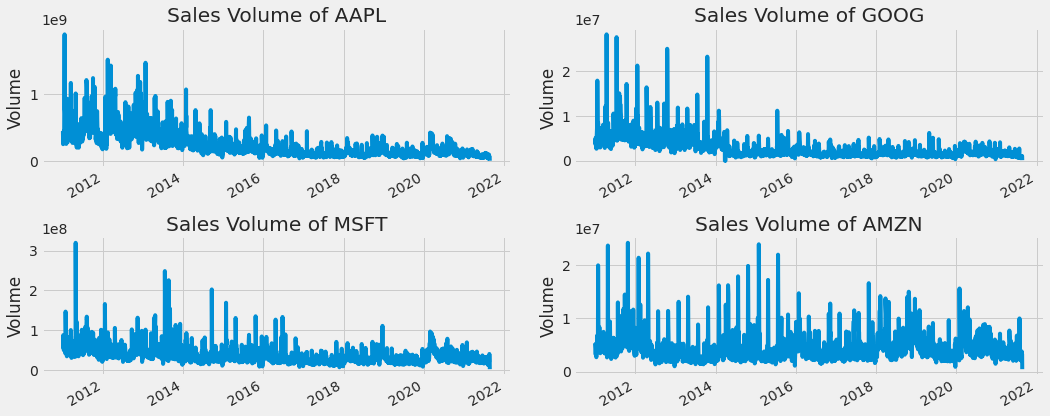

In [ ]:
# Let's see a historical view of the closing price


plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    stock_prices[company]['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume of {tech_list[i - 1]}")
    
plt.tight_layout()

### Daily return

$ return = \frac{new - old}{old} $

In [ ]:
for company in company_list:
    stock_prices[company]['Daily Return'] = stock_prices[company]['Adj Close'].pct_change()

In [ ]:
stock_prices["AAPL"]

,High,Low,Open,Close,Volume,Adj Close,company_name,Daily Return
Date,,,,,,,,
2011-01-03,11.795000,11.601429,11.630000,11.770357,445138400.0,10.106220,APPLE,NaN
2011-01-04,11.875000,11.719643,11.872857,11.831786,309080800.0,10.158968,APPLE,0.005219
2011-01-05,11.940714,11.767857,11.769643,11.928571,255519600.0,10.242065,APPLE,0.008180
2011-01-06,11.973214,11.889286,11.954286,11.918929,300428800.0,10.233788,APPLE,-0.000808
2011-01-07,12.012500,11.853571,11.928214,12.004286,311931200.0,10.307076,APPLE,0.007161
...,...,...,...,...,...,...,...,...
2021-08-18,150.720001,146.149994,149.800003,146.360001,86326000.0,146.360001,APPLE,-0.025501
2021-08-19,148.000000,144.500000,145.029999,146.699997,86960300.0,146.699997,APPLE,0.002323
2021-08-20,148.500000,146.779999,147.440002,148.190002,59947400.0,148.190002,APPLE,0.010157


In [ ]:
stock_prices["AAPL"]['Adj Close']

Date
2011-01-03     10.106220
2011-01-04     10.158968
2011-01-05     10.242065
2011-01-06     10.233788
2011-01-07     10.307076
                 ...    
2021-08-18    146.360001
2021-08-19    146.699997
2021-08-20    148.190002
2021-08-23    149.710007
2021-08-24    150.544998
Name: Adj Close, Length: 2679, dtype: float64

In [ ]:
# penultimate_known_value_appl 
old =  stock_prices["AAPL"]['Adj Close'][-2]
print(f"penultimate value of the AAPL stock price = {old}")
# last_known_value_appl 
new = stock_prices["AAPL"]['Adj Close'][-1]
print(f"last known value of the AAPL stock price = {new}")
# percentage change
print(f"percentage of change = {round((new-old)/old,6)}")

penultimate value of the AAPL stock price = 149.7100067138672
last known value of the AAPL stock price = 150.5449981689453
percentage of change = 0.005577


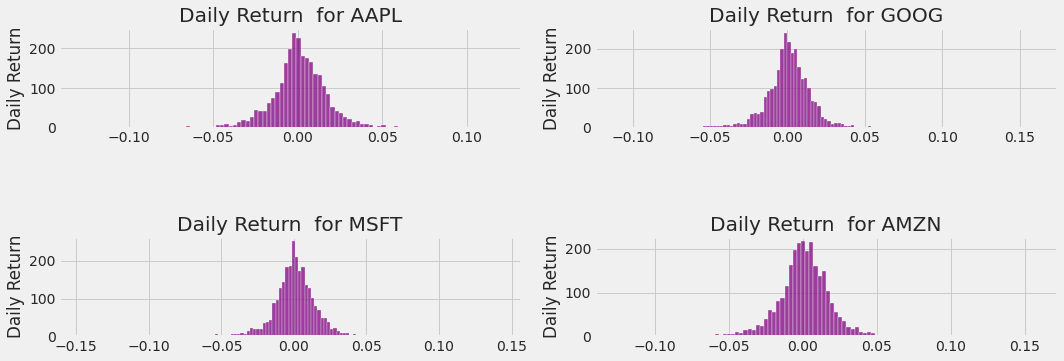

In [ ]:

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data = stock_prices[company], x = 'Daily Return', color="purple")
    plt.ylabel('Daily Return')
    plt.xlabel(None)
    plt.title(f"Daily Return  for {tech_list[i - 1]}")
    
plt.tight_layout()

In [ ]:
company_list

['AAPL', 'GOOG', 'MSFT', 'AMZN']

In [ ]:
closing_df = DataReader(company_list, "yahoo", start, end)["Adj Close"]

In [ ]:
closing_df.tail(5)

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2021-08-18,146.360001,2731.399902,290.730011,3201.219971
2021-08-19,146.699997,2738.270020,296.769989,3187.750000
2021-08-20,148.190002,2768.739990,304.359985,3199.949951
2021-08-23,149.710007,2821.989990,304.649994,3265.870117
2021-08-24,150.570206,2844.810059,304.000000,3280.469971


In [ ]:
daily_returns = closing_df.pct_change()
daily_returns

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2011-01-03,NaN,NaN,NaN,NaN
2011-01-04,0.005219,-0.003690,0.003931,0.004288
2011-01-05,0.008180,0.011543,-0.003204,0.013026
2011-01-06,-0.000808,0.007273,0.029286,-0.008324
2011-01-07,0.007161,0.004792,-0.007633,-0.001991
...,...,...,...,...
2021-08-18,-0.025501,-0.005320,-0.006119,-0.012566
2021-08-19,0.002323,0.002515,0.020775,-0.004208
2021-08-20,0.010157,0.011127,0.025575,0.003827


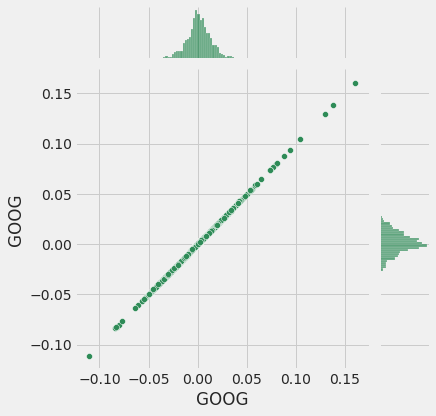

In [ ]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x = 'GOOG', y = 'GOOG', data = daily_returns, kind='scatter', color='seagreen')

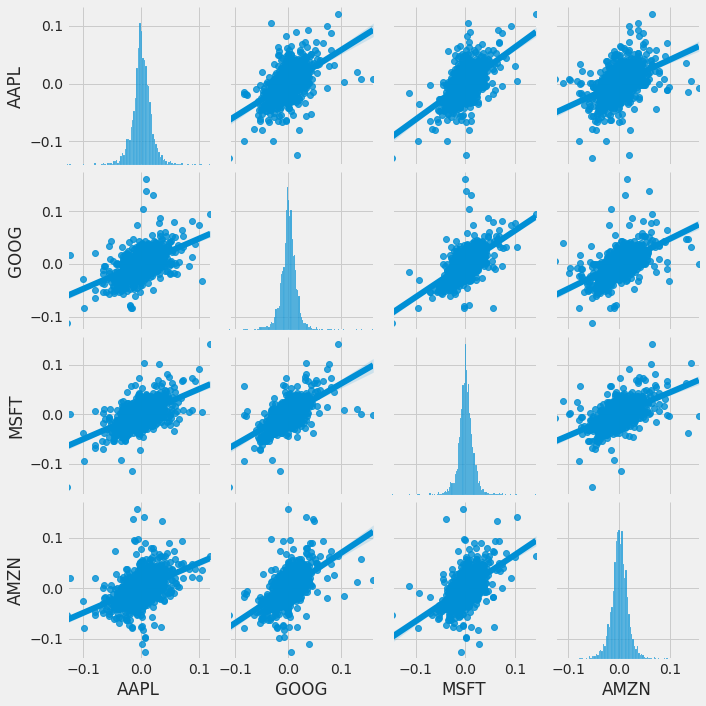

In [ ]:
sns.pairplot(daily_returns, kind="reg")

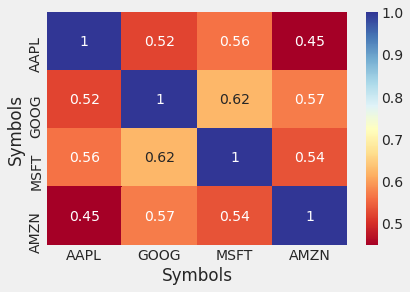

In [ ]:
sns.heatmap(daily_returns.corr(),annot=True, cmap="RdYlBu")

## Apple Stock Price

`Apple`, `Google`, `Microsoft` and `Amazon` look quite correlated.

But first, let's try to predict the AAPL stock price without using its competitors' info.

In [ ]:
aapl = stock_prices["AAPL"]
aapl.tail(5)

,High,Low,Open,Close,Volume,Adj Close,company_name,Daily Return
Date,,,,,,,,
2021-08-18,150.720001,146.149994,149.800003,146.360001,86326000.0,146.360001,APPLE,-0.025501
2021-08-19,148.000000,144.500000,145.029999,146.699997,86960300.0,146.699997,APPLE,0.002323
2021-08-20,148.500000,146.779999,147.440002,148.190002,59947400.0,148.190002,APPLE,0.010157
2021-08-23,150.190002,147.889999,148.309998,149.710007,60007400.0,149.710007,APPLE,0.010257
2021-08-24,150.860001,149.149994,149.449997,150.544998,10589769.0,150.544998,APPLE,0.005577


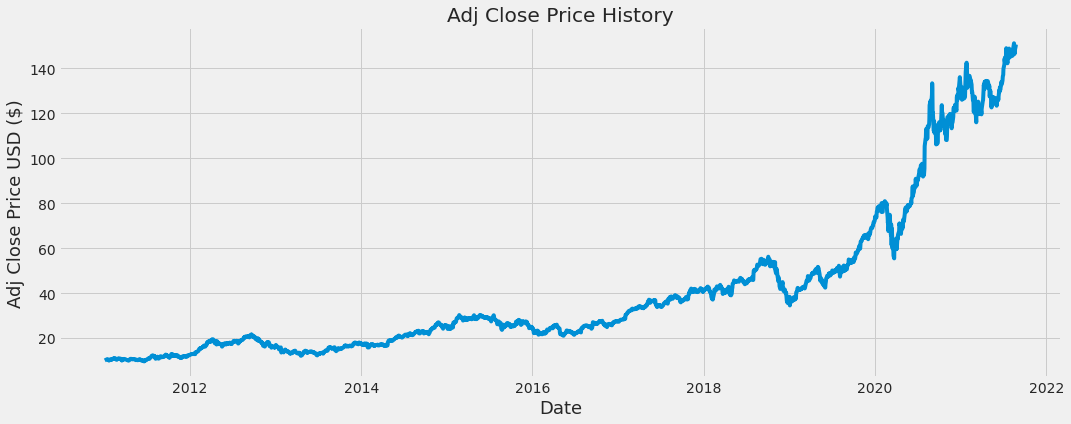

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Adj Close Price History')
plt.plot(aapl['Adj Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price USD ($)', fontsize=18)
plt.show()

### Neural Networks require tensors/arrays...

In [ ]:
data = aapl[["Close"]].values
print(type(data))
display(data)
print(data.shape)

<class 'numpy.ndarray'>


array([[ 11.77035713],
       [ 11.83178616],
       [ 11.92857075],
       ...,
       [148.19000244],
       [149.71000671],
       [150.54499817]])

(2679, 1)


### Temporal Train-Test Split

❌ We can't do a traditional holdout method due to the temporal nature of our dataset. 

☢️ It would cause a data leakage... 

👉 So let's do it manually.

In [ ]:
train_percentage = 95

In [ ]:
train_len = int(len(data) * train_percentage/100)
train_len

2545

In [ ]:
len(data)

2679

In [ ]:
data_train = data[:train_len]
data_test = data[train_len:]

In [ ]:
len(data_train)

2545

In [ ]:
window_size = 3
horizon = 1

```python
def my_beautiful_function():
  return blabla
```

```sql
SELECT *
FROM my_table
```

In [ ]:
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train)-(window_size-1)-horizon):
  data_train_subsequences.append(data_train[k:k+window_size])
  fake_y_train.append(data_train[k+window_size])

In [ ]:
len(data_train_subsequences)

2543

In [ ]:
len(data_train) - window_size + 1

2543

In [ ]:
np.array(data_train_subsequences).shape

(2543, 3, 1)

## Data Preparation

### Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [ ]:
minmax_scaler.data_max_

array([143.16000366])

In [ ]:
minmax_scaler.data_min_

array([11.26142883])

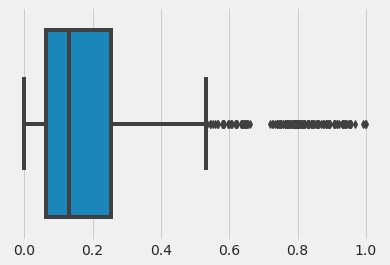

In [ ]:
# double check that the train dataset has been min-max scaled
sns.boxplot(x = data_train_scaled)

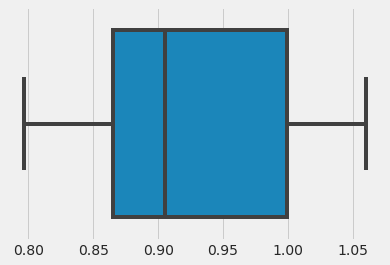

In [ ]:
# double check that the test dataset has been min-max scaled
sns.boxplot(x = data_test_scaled)

### Creating subsequences...

**Draft**

In [ ]:
# creating a subsequence with 5 days/week x 4 weeks/month x 3 months = 60 days
length = 5*4*3

# predicting what is happening on the day 61, 62, 63, 64, 65
horizon  = 1

In [ ]:
len(data_train)

2545

In [ ]:
last_possible_start = len(data_train) - length - horizon
last_possible_start

2484

In [ ]:
random_start = np.random.randint(0, last_possible_start)
random_start

351

In [ ]:
one_subsequence = data_train[random_start:random_start + length]
one_subsequence.shape

(60, 1)

In [ ]:
one_target = data_train[random_start + length + horizon:random_start + length + horizon+5]
print(one_target.shape)
one_target

(5, 1)


array([[23.43071365],
       [23.88821411],
       [23.66535759],
       [23.68642807],
       [24.13142967]])

**`subsequence`**

In [ ]:
def subsequence(df, length, horizon):
    last_possible_start = len(df) - length - horizon
    random_start = np.random.randint(0, last_possible_start)
    X = df[random_start:random_start + length]
    y = df[random_start + length + horizon][0]
    
    return X, y

In [ ]:
length = 60
horizon  = 1

X, y = subsequence(data_train, length, horizon)

In [ ]:
X.shape

(60, 1)

In [ ]:
X[-5:]

array([[21.5714283 ],
       [21.26142883],
       [21.30500031],
       [20.60000038],
       [20.87928581]])

In [ ]:
y

19.928571701049805

In [ ]:
len(data_test)

134

**`multiple_subsequences`**

In [ ]:
np.random.randint(40, 61, 100)

array([43, 41, 56, 59, 56, 52, 42, 60, 58, 53, 57, 58, 49, 47, 48, 56, 43,
       53, 51, 49, 57, 53, 57, 60, 56, 42, 57, 43, 58, 49, 56, 44, 40, 57,
       42, 43, 60, 49, 42, 48, 56, 56, 51, 59, 60, 43, 53, 55, 52, 51, 45,
       44, 48, 40, 44, 51, 44, 52, 44, 42, 53, 49, 42, 43, 52, 43, 50, 41,
       40, 60, 58, 55, 51, 52, 53, 56, 40, 42, 44, 54, 46, 51, 60, 44, 60,
       57, 55, 49, 47, 43, 44, 40, 44, 55, 55, 54, 40, 53, 41, 44])

In [ ]:
def multiple_subsequences(df, number_of_subsequences,horizon = 1):
    
    list_of_X = []
    list_of_y = []
    
    # we'll generate number_of_subsequences subsequences with random lengths between 40 and 60 days

    list_of_lengths = np.random.randint(40, 61, number_of_subsequences) 
    
    for (_, length) in zip(range(number_of_subsequences),list_of_lengths):
        tmp_X, tmp_y = subsequence(df, length, horizon)
        list_of_X.append(tmp_X)
        list_of_y.append(tmp_y)
        
    
    return list_of_X, list_of_y

    
    
    

In [ ]:
X_train, y_train = multiple_subsequences(data_train_scaled, 2000, horizon = 1)
X_test, y_test = multiple_subsequences(data_test_scaled, 1000,horizon = 1)

## LSTM

### Padding...

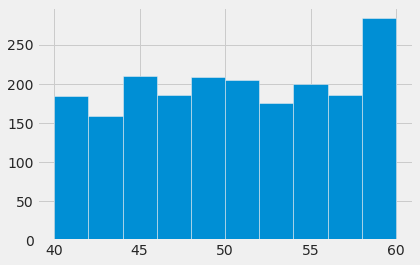

In [ ]:
plt.hist([len(_) for _ in X_train]);

(array([ 95., 100.,  92.,  74., 106.,  96.,  92., 107.,  94., 144.]),
 array([40., 42., 44., 46., 48., 50., 52., 54., 56., 58., 60.]),
 <a list of 10 Patch objects>)

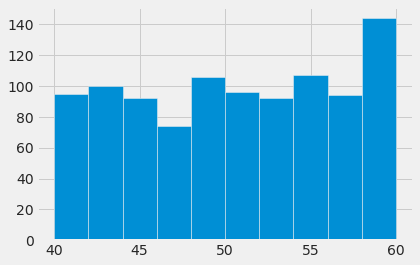

In [ ]:
plt.hist([len(_) for _ in X_test])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train, value = -999, padding = "post", dtype="float64")
X_test_pad = pad_sequences(X_test, value = -999, padding = "post", dtype="float64")

In [ ]:
X_train_pad.shape

(2000, 60, 1)

In [ ]:
X_test_pad.shape

(1000, 60, 1)

### RNN Architecture

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import metrics

# Build the LSTM model

def my_rnn_model():
  model = Sequential()

  model.add(layers.Masking(mask_value=-999))

  model.add(layers.LSTM(units=128,
                      return_sequences = True,
                      activation = "tanh",
                      input_shape = X_train_pad[0].shape))

  model.add(layers.LSTM(units=64,
                        return_sequences = False,
                        activation = "tanh"))

  model.add(layers.Dense(25,
                          activation="relu"))

  model.add(layers.Dense(1,
                        activation="relu"))
  
  my_mae = metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)

  model.compile(loss="mse",
              optimizer = "rmsprop",
              metrics = [my_mae])
  
  return model

model = my_rnn_model()



NameError: ignored

In [ ]:
   dr

### Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 25, monitor = "val_mean_absolute_error")


history = model.fit(X_train_pad, np.array(y_train),
          validation_split = 0.3,
         batch_size=16,
         epochs=300,
         verbose = 1,
         callbacks = [es])

Epoch 1/300
88/88 [==============================] - 21s 135ms/step - loss: 0.0050 - mean_absolute_error: 0.0344 - val_loss: 0.0073 - val_mean_absolute_error: 0.0702
Epoch 2/300
88/88 [==============================] - 10s 110ms/step - loss: 0.0016 - mean_absolute_error: 0.0233 - val_loss: 2.8575e-04 - val_mean_absolute_error: 0.0100
Epoch 3/300
88/88 [==============================] - 10s 111ms/step - loss: 0.0013 - mean_absolute_error: 0.0212 - val_loss: 2.8345e-04 - val_mean_absolute_error: 0.0112
Epoch 4/300
88/88 [==============================] - 10s 111ms/step - loss: 9.5819e-04 - mean_absolute_error: 0.0196 - val_loss: 0.0033 - val_mean_absolute_error: 0.0473
Epoch 5/300
88/88 [==============================] - 10s 110ms/step - loss: 7.1793e-04 - mean_absolute_error: 0.0167 - val_loss: 4.5779e-04 - val_mean_absolute_error: 0.0129
Epoch 6/300
88/88 [==============================] - 10s 111ms/step - loss: 5.7747e-04 - mean_absolute_error: 0.0164 - val_loss: 8.2262e-04 - val_mean

In [ ]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

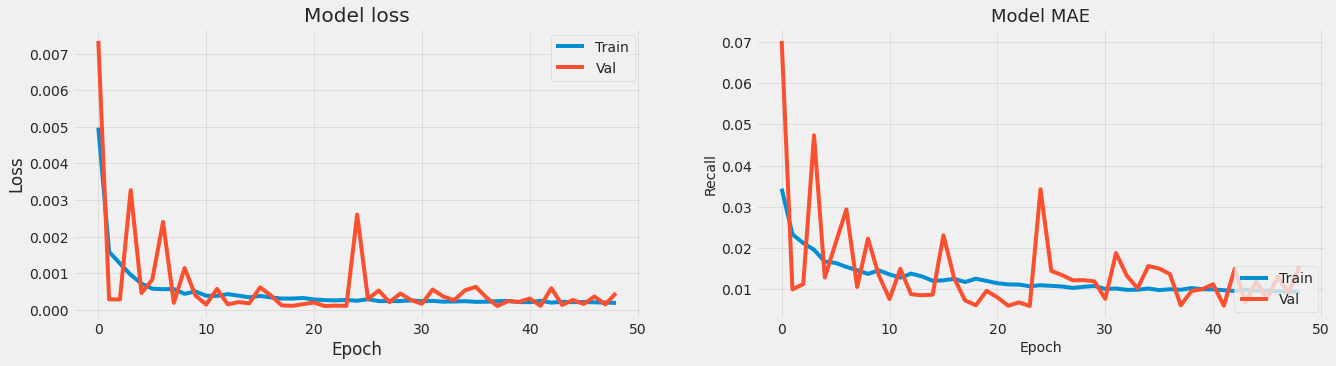

In [ ]:
plot_loss_mae(history)

### Evaluating

In [ ]:
res = model.evaluate(X_test_pad, np.array(y_test), verbose = 1)
res


32/32 [==============================] - 1s 33ms/step - loss: 0.0031 - mean_absolute_error: 0.0523


[0.003105105133727193, 0.05230402573943138]

### Predictions

In [ ]:
predictions = model.predict(X_test_pad)

In [ ]:
len(predictions)

1000

In [ ]:
len(y_test)

1000

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [ ]:
a = minmax_scaler.data_min_
b = minmax_scaler.data_max_

In [ ]:
unscaled_predictions_manually_computed = predictions * (b - a) + a

In [ ]:
unscaled_predictions = minmax_scaler.inverse_transform(predictions)

In [ ]:
np.allclose(unscaled_predictions,unscaled_predictions_manually_computed)

True

In [ ]:
unscaled_y_test = minmax_scaler.inverse_transform(np.array([y_test])).T

In [ ]:
unscaled_predictions.shape

(1000, 1)

In [ ]:
unscaled_y_test.shape

(1000, 1)

In [ ]:
#MAE
np.mean(np.abs(unscaled_y_test - unscaled_predictions))

6.898828765869135

In [ ]:
#RMSE
np.sqrt(np.mean((unscaled_y_test - unscaled_predictions)**2))

7.349847510972382

In [ ]:
predictions_train = model.predict(X_train_pad)
unscaled_predictions_train = minmax_scaler.inverse_transform(predictions_train)
unscaled_y_train = minmax_scaler.inverse_transform(np.array([y_train])).T
np.mean(np.abs(unscaled_y_train - unscaled_predictions_train))

1.9941250491142273

Problem: we were not able to detect overfitting with the scaled data...

The RMSE on the train set is amazing (less than 1 USD) but not great on the test set (approx 7 USD)...

## Baseline

When predicting a continous value, the baseline model is to predict `y_train.mean()`. 

For a Time-Series, it may not be relevant to consider the mean on the train set if there is a change of paradigm.

The last seen value is more appropriate.

In [ ]:
# baseline predictions

X_test_last_seen_value = [_[-1][0] for _ in X_test]

In [ ]:
X_test_last_seen_value_unscaled = minmax_scaler.inverse_transform(np.array(X_test_last_seen_value).reshape(-1,1))

In [ ]:
#MAE
np.mean(np.abs(unscaled_y_test - X_test_last_seen_value_unscaled))

1.8263999786376954

In [ ]:
#RMSE
np.sqrt(np.mean((unscaled_y_test - X_test_last_seen_value_unscaled)**2))

2.298186114917393

## LSTM using Tech competitors

### Tech industries

In [ ]:
closing_df.tail(5)

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2021-08-17,150.190002,2746.010010,292.519989,3241.959961
2021-08-18,146.360001,2731.399902,290.730011,3201.219971
2021-08-19,146.699997,2738.270020,296.769989,3187.750000
2021-08-20,148.190002,2768.739990,304.359985,3199.949951
2021-08-23,149.710007,2821.989990,304.649994,3265.870117


In [ ]:
closing_df.shape

(2678, 4)

In [ ]:
tech_stock_prices = closing_df.copy()

### Temporal Train-Test Split

In [ ]:
train_percentage = 95

In [ ]:
train_len = int(len(tech_stock_prices) * train_percentage/100)
train_len

2544

In [ ]:
len(tech_stock_prices)

2678

In [ ]:
tech_train = tech_stock_prices[:train_len]
tech_test = tech_stock_prices[train_len:]

In [ ]:
print(tech_train.shape)
print(tech_test.shape)

(2544, 4)
(134, 4)


### Scaling


In [ ]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler_bis = MinMaxScaler()

minmax_scaler_bis.fit(np.array(tech_train))

tech_train_scaled = pd.DataFrame(minmax_scaler_bis.transform(np.array(tech_train)), columns = tech_stock_prices.columns)
tech_test_scaled = pd.DataFrame(minmax_scaler_bis.transform(np.array(tech_test)), columns = tech_stock_prices.columns)

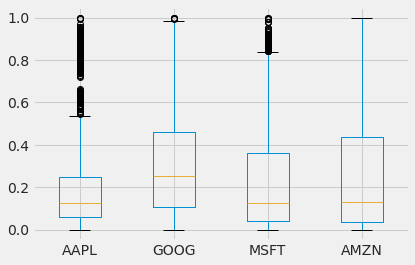

In [ ]:
tech_train_scaled.boxplot()

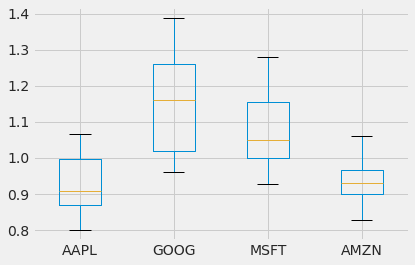

In [ ]:
tech_test_scaled.boxplot()

### Creating subsequences bis-repetita

In [ ]:
tech_stock_prices.shape

(2678, 4)

In [ ]:
# creating a subsequence with 5 days/week x 4 weeks/month x 3 months = 60 days
length = 5*4*3

# predicting what is happening on the day 61
horizon  = 1

In [ ]:
last_possible_start = len(tech_train) - length - horizon
last_possible_start

2483

In [ ]:
random_start = np.random.randint(0, last_possible_start)
random_start

1630

In [ ]:
one_subsequence = tech_train[random_start:random_start + length]
print(one_subsequence.shape)
one_subsequence.tail()

(60, 4)


Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2017-09-13,38.091831,935.090027,71.262939,999.599976
2017-09-14,37.764954,925.109985,70.846031,992.210022
2017-09-15,38.146713,920.289978,71.357674,986.789978
2017-09-18,37.858009,915.000000,71.215561,974.190002
2017-09-19,37.872318,921.809998,71.480873,969.859985


In [ ]:
one_target = tech_train.iloc[random_start + length + horizon]['AAPL']
one_target

36.59821319580078

`subsequence`

In [ ]:
def subsequence_apple_competitors(df, length, horizon):
    last_possible_start = len(df) - length - horizon
    random_start = np.random.randint(0, last_possible_start)
    X = df[random_start:random_start + length]
    y = df.iloc[random_start + length + horizon]['AAPL']
    
    return X, y

In [ ]:
length

60

In [ ]:
horizon

1

In [ ]:
one_subsequence, one_target = subsequence_apple_competitors(tech_stock_prices, length, horizon)

In [ ]:
one_subsequence.shape

(60, 4)

In [ ]:
one_subsequence

Symbols,AAPL,GOOG,MSFT,AMZN
Date,,,,
2019-07-03,50.086777,1121.579956,134.229919,1939.000000
2019-07-05,50.042667,1131.589966,133.839325,1942.910034
2019-07-08,49.011086,1116.349976,133.741669,1952.319946
2019-07-09,49.310032,1124.829956,133.253418,1988.300049
2019-07-10,49.797630,1140.479980,134.610764,2017.410034
2019-07-11,49.434998,1144.209961,135.147812,2001.069946
2019-07-12,49.814785,1144.900024,135.636078,2011.000000
2019-07-15,50.282806,1150.339966,135.636078,2020.989990
2019-07-16,50.108826,1153.579956,133.858856,2009.900024


In [ ]:
one_target

55.08809280395508

`multiple subsequences`

In [ ]:
list_of_lengths = np.random.randint(40, 61, 100) 
list_of_lengths

array([54, 40, 46, 45, 53, 46, 53, 43, 43, 51, 51, 55, 58, 43, 49, 46, 46,
       55, 45, 57, 59, 43, 57, 54, 56, 51, 52, 58, 45, 47, 44, 58, 53, 51,
       45, 46, 55, 50, 50, 50, 60, 53, 40, 48, 56, 45, 55, 54, 45, 51, 51,
       51, 40, 54, 53, 42, 57, 49, 58, 45, 56, 40, 53, 59, 45, 54, 50, 56,
       51, 59, 40, 40, 55, 44, 55, 43, 49, 60, 46, 57, 53, 43, 59, 59, 53,
       42, 54, 51, 60, 57, 56, 55, 59, 60, 48, 53, 42, 55, 40, 45])

In [ ]:
def multiple_subsequences_apple_competitors(df, number_of_subsequences,horizon = 1):
    
    list_of_X = []
    list_of_y = []
    
    # we'll generate number_of_subsequences subsequences with random lengths between 40 and 60 days

    list_of_lengths = np.random.randint(40, 61, number_of_subsequences) 
    
    for (_, length) in zip(range(number_of_subsequences),list_of_lengths):
        tmp_X, tmp_y = subsequence_apple_competitors(df, length, horizon)
        list_of_X.append(tmp_X)
        list_of_y.append(tmp_y)
        
    
    return list_of_X, list_of_y

In [ ]:
X_train_apple_competition, y_train_apple = multiple_subsequences_apple_competitors(tech_train_scaled, 2000,horizon = 1)
X_test_apple_competition, y_test_apple = multiple_subsequences_apple_competitors(tech_test_scaled, 1000,horizon = 1)

### Padding

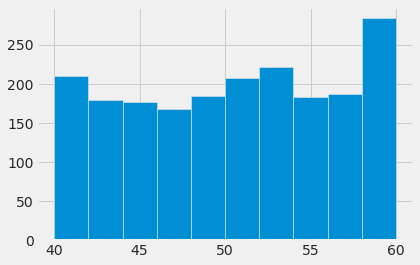

In [ ]:
plt.hist([len(_) for _ in X_train_apple_competition]);

(array([118., 101., 102.,  89.,  95.,  76., 110.,  79., 102., 128.]),
 array([40., 42., 44., 46., 48., 50., 52., 54., 56., 58., 60.]),
 <a list of 10 Patch objects>)

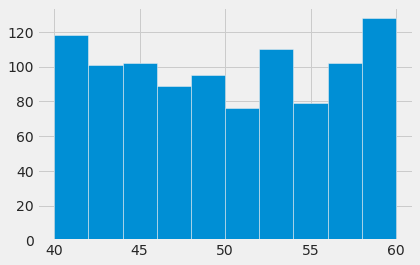

In [ ]:
plt.hist([len(_) for _ in X_test_apple_competition])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad_apple_competition = pad_sequences(X_train_apple_competition, value = -999, padding = "post", dtype="float64")
X_test_pad_apple_competition = pad_sequences(X_test_apple_competition, value = -999, padding = "post", dtype="float64")

In [ ]:
X_train_pad_apple_competition.shape

(2000, 60, 4)

In [ ]:
X_test_pad_apple_competition.shape

(1000, 60, 4)

### Re-using the previous architecture

In [ ]:
lstm_new = my_rnn_model()

### Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 20, monitor = "val_mean_absolute_error")


history_new = lstm_new.fit(X_train_pad_apple_competition, np.array(y_train_apple),
          validation_split = 0.3,
         batch_size=16,
         epochs=100,
         verbose = 1,
         callbacks = [es])

Epoch 1/100
88/88 [==============================] - 21s 136ms/step - loss: 0.0047 - mean_absolute_error: 0.0409 - val_loss: 7.0476e-04 - val_mean_absolute_error: 0.0213
Epoch 2/100
88/88 [==============================] - 10s 110ms/step - loss: 0.0021 - mean_absolute_error: 0.0284 - val_loss: 3.5233e-04 - val_mean_absolute_error: 0.0141
Epoch 3/100
88/88 [==============================] - 10s 110ms/step - loss: 0.0014 - mean_absolute_error: 0.0229 - val_loss: 4.6784e-04 - val_mean_absolute_error: 0.0165
Epoch 4/100
88/88 [==============================] - 10s 110ms/step - loss: 0.0011 - mean_absolute_error: 0.0211 - val_loss: 9.2334e-04 - val_mean_absolute_error: 0.0221
Epoch 5/100
88/88 [==============================] - 10s 109ms/step - loss: 0.0010 - mean_absolute_error: 0.0198 - val_loss: 5.8920e-04 - val_mean_absolute_error: 0.0165
Epoch 6/100
88/88 [==============================] - 10s 110ms/step - loss: 7.8527e-04 - mean_absolute_error: 0.0180 - val_loss: 8.6196e-04 - val_mean

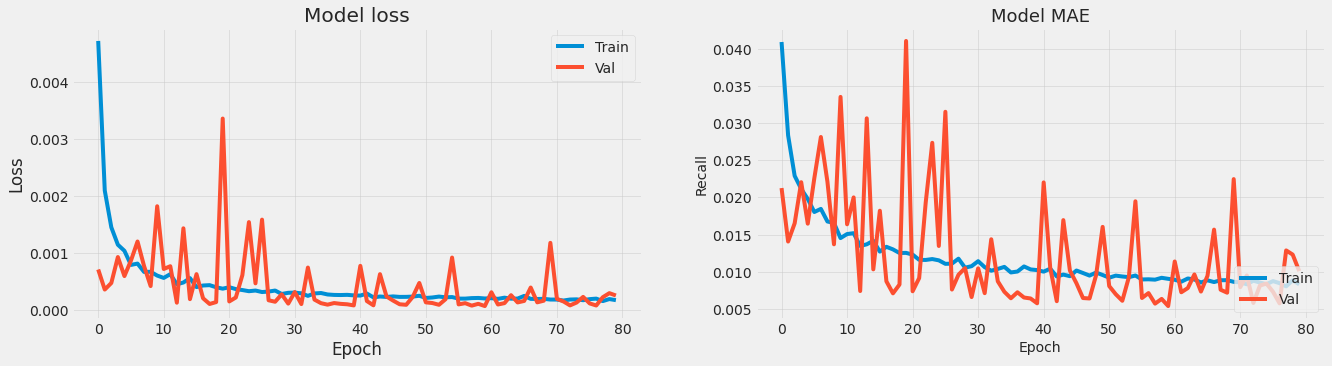

In [ ]:
plot_loss_mae(history_new)

### Evaluating

In [ ]:
res_new = lstm_new.evaluate(X_test_pad_apple_competition, np.array(y_test_apple), verbose = 1)
res_new


32/32 [==============================] - 1s 33ms/step - loss: 6.1131e-04 - mean_absolute_error: 0.0202


[0.0006113072158768773, 0.020239485427737236]

### Predictions

In [ ]:
predictions_new = lstm_new.predict(X_test_pad_apple_competition)

In [ ]:
minmax_scaler_bis.data_min_

array([  9.66924477, 236.55334473,  18.96278763, 160.97000122])

In [ ]:
minmax_scaler_bis.data_max_

array([ 142.49052429, 2098.        ,  242.18589783, 3531.44995117])

In [ ]:
minmax_scaler_bis.data_range_

array([ 132.82127953, 1861.44665527,  223.2231102 , 3370.47994995])

In [ ]:
apple_train_min = minmax_scaler_bis.data_min_[0]
apple_train_max = minmax_scaler_bis.data_max_[0]
apple_train_range = minmax_scaler_bis.data_range_[0]

In [ ]:
unscaled_predictions_new = predictions_new * apple_train_range + apple_train_min

In [ ]:
unscaled_y_test_apple = np.array(y_test_apple) * apple_train_range + apple_train_min

In [ ]:
#MAE
np.mean(np.abs(unscaled_y_test_apple - unscaled_predictions_new))

10.39947192997742

In [ ]:
#RMSE
np.sqrt(np.mean((unscaled_y_test_apple - unscaled_predictions_new)**2))

12.884107829805409

In [ ]:
predictions_train_new = model.predict(X_train_pad_apple_competition)
unscaled_predictions_train_new = minmax_scaler_bis.inverse_transform(predictions_train_new)
unscaled_y_train_apple = minmax_scaler.inverse_transform(np.array([y_train_apple])).T
np.mean(np.abs(unscaled_y_train_apple - unscaled_predictions_train_new))

## LSTM easy 

FROM KAGGLE

A bit too easy, the guy created as many subsequences as possible, without any randomness in the lengeth of them (so not need to pad anything)

In [ ]:
dataset_apple = aapl[["Close"]].values
dataset_apple

array([[ 11.77035713],
       [ 11.83178616],
       [ 11.92857075],
       ...,
       [146.69999695],
       [148.19000244],
       [149.71000671]])

In [ ]:
len(dataset_apple)

2678

In [ ]:
training_data_length = int(np.ceil(len(dataset_apple
) * 0.95))
training_data_length

2545

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset_apple
)

scaled_data

array([[0.00363888],
       [0.0040781 ],
       [0.00477012],
       ...,
       [0.96839666],
       [0.97905032],
       [0.98991847]])

In [ ]:
# Create the training data set 
# Create the scaled training data set

train_data = scaled_data[0:int(training_data_length), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 #   if i<= 61:
 #       print(x_train)
 #       print(y_train)
 #       print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

NameError: ignored

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 543 to 2002 
test_data = scaled_data[training_data_length - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset_apple[training_data_length:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
# Plot the data
train = aapl[:training_data_length]
valid = aapl[training_data_length:]

In [ ]:
valid

In [ ]:

valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()